In [1]:
import os
os.environ["HF_HOME"] = "/Volumes/T7/.cache/huggingface"

In [4]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="tiiuae/falcon-40b", device="mps", offload_folder="offload")

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

: 

In [17]:
import jax.numpy as np
# import numpy as np

# We can't use a straight forward Euler scheme because that would require us to solve a 
# tridiagonal matrix equation at every time point. Instead we solve it once and for all at 
# jthe beginning using a Lanczos algorithm, which gives us the evolution operator $U(t) = 
# e^{-iHt/\hbar}$. The linear part is then simply exp(-iVt), where V is the potential term. 
# We can then proceed with the Trotter-Suzuki decomposition

class Quantity:
    def __init__(self, t, delta_t):
        self.t = t
        self.delta_t = delta_t
        n_steps = int(t/delta_t)
        
        # Initial values
        self.x = 1.0 + 0.0*1j
        self.y = -1.0 + 0.0*1j
    
        # Eigenvalues and basis functions for the potential term, which is now diagonal in x and y coordinates due to the rotating frame
        lam_x, lam_y = np.meshgrid(np.linspace(-2, 2, n_steps), np.linspace(-2, 2, n_steps))
        
        self.basis_psi_x = np.cos(np.pi*lam_x)
        self.basis_psi_y = np.cos(np.pi*lam_y)
        self.basis_phi_x = np.sin(np.pi*lam_x)
        self.basis_phi_y = np.sin(np.pi*lam_y)
        
        # Basis for the time-dependent part of H, which we compute in a numerically stable way by exponentiating only the eigenvalues and then reconstructing the operator in the original basis using the eigenbasis
        self.phi_x = np.exp(-np.pi*lam_x)
        self.phi_y = np.exp(-np.pi*lam_y)
    
    def compute(self):
        
        # Rotation factors for the x and y operator in the rotating frame. This is simply a phase factor
        self.c_x = np.exp(np.sqrt(-2)*self.t)
        self.c_y = np.exp(-np.sqrt(-2)*self.t)
        
        # The unitary operator for the time-dependent part of H
        print("big unitary matrices")
        U = (self.phi_x**(0.5/self.delta_t))[:, None]*self.basis_psi_x + self.phi_y**(0.5/self.delta_t)*self.basis_psi_y  # Operator for first half step
        U += (self.phi_x**(-0.5/self.delta_t))[:, None]*self.basis_phi_x + self.phi_y**(-0.5/self.delta_t)*self.basis_phi_y  # Operator for second half step
        
        # We rotate into the rotating frame and then apply H, which is simply an exponential decay on both x and y
        self.x = self.c_x*U[:, 0]
        self.y = self.c_y*U[:, 1]
        
        return self.x, self.y

def plot_data(t, data, name):
    import matplotlib.pyplot as plt
    median = np.median(np.real(data), axis=0)
    
    mean = np.mean(np.real(data), axis=0)
    std = np.std(np.real(data), axis=0)/np.sqrt(n_runs)
    plt.plot(t, median, label="Median")
    plt.fill_between(t, mean-std, mean+std, alpha=0.5, label="Average $\pm \sigma$")
    #plt.errorbar(t, mean, yerr=std)
    
    plt.title("Data for {}".format(name))
    plt.xlabel("Time [1/J]")
    plt.ylabel("{} [arb.]".format(name))
    plt.savefig("plots/{}.pdf".format(name), bbox_inches="tight")
    plt.show()
    

In [18]:
i = np.array([np.sqrt(-1)])

In [19]:
j = np.array([1.0 * 1j])

In [20]:
j.dtype

dtype('complex64')

big unitary matrices


KeyboardInterrupt: 

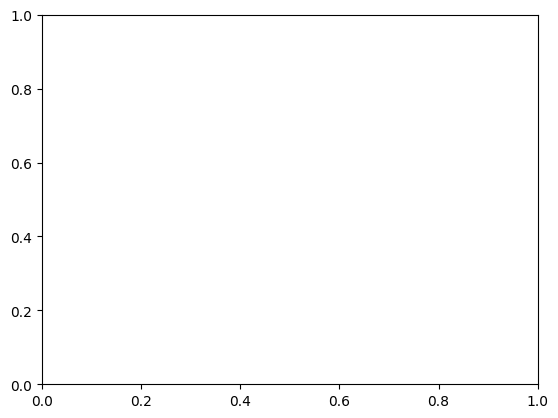

In [21]:

from matplotlib import pyplot as plt


n_runs = 1
t = np.linspace(0, 256, 2**4)

q = Quantity(t[-1], 0.2)
x, y = q.compute()
plt.plot(x, y)
# plot_data(t, x, "x")
# plot_data(t, y, "y")

In [6]:
x.shape

(1280, 1280)

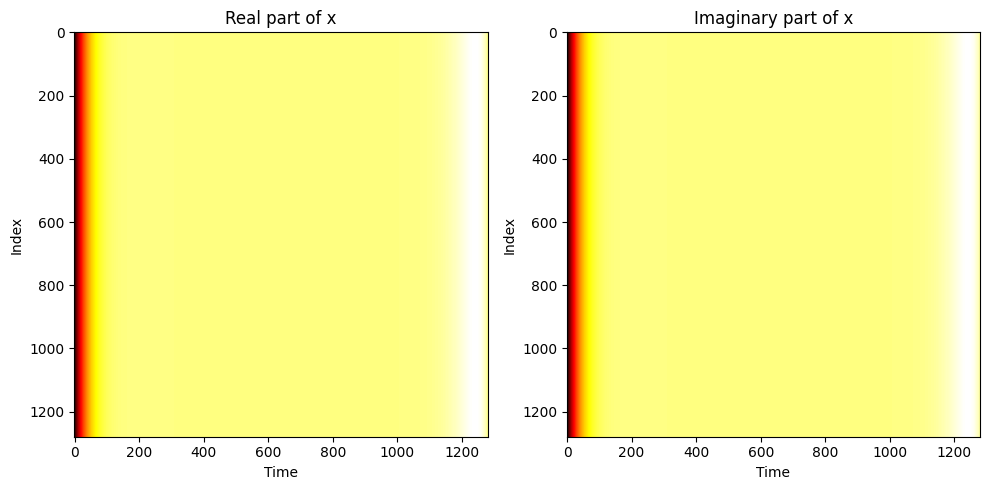

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(x.real, cmap='hot', aspect='auto')
axs[0].set_title('Real part of x')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Index')

axs[1].imshow(x.imag, cmap='hot', aspect='auto')
axs[1].set_title('Imaginary part of x')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Index')

plt.tight_layout()
plt.show()


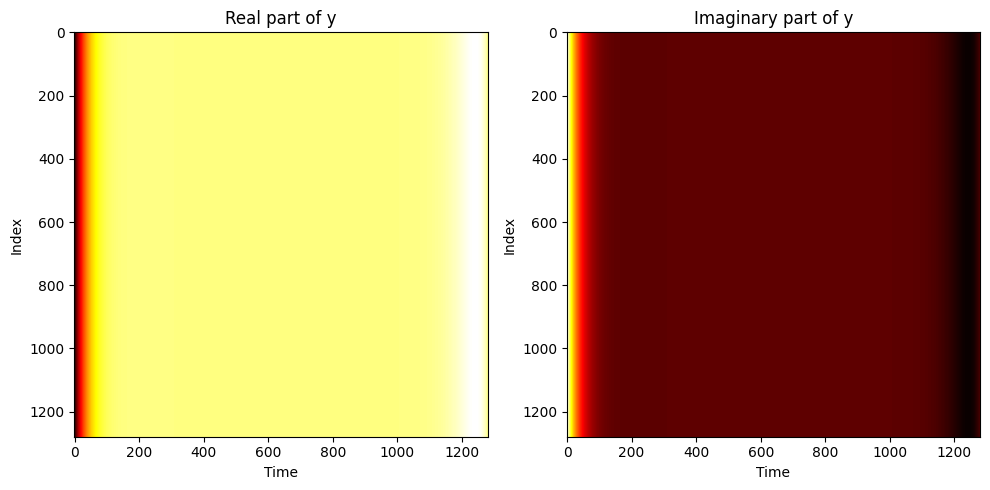

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(y.real, cmap='hot', aspect='auto')
axs[0].set_title('Real part of y')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Index')

axs[1].imshow(y.imag, cmap='hot', aspect='auto')
axs[1].set_title('Imaginary part of y')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Index')

plt.tight_layout()
plt.show()
